In [7]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.tikhonov as tikhonov
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd

  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.
  Convergence criterion reached in 17 iterations.


  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.
  Convergence criterion reached in 16 iterations.


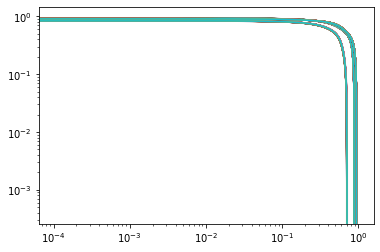

In [9]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/Lorenz63_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)

# noise_lvls = [0.001, 0.01, 0.1, 1, 2]
noise_lvls = [0.01]

n_noise_lvls = len(noise_lvls)

mean_dX_error = np.zeros((n_states, n_noise_lvls))
var_dX_error = np.zeros((n_states, n_noise_lvls))  

for noise, sigma in enumerate(noise_lvls):

    # 2) LOAD OBSERVATION SAMPLES
    Y_samples = []
    noise_lvl = str(sigma)

    for state in range(n_states):

        filepath = 'data_files/Lorenz63_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
        y = np.genfromtxt(filepath, delimiter=',')

        Y_samples.append(y)

    n_samples = Y_samples[0].shape[0]

    ################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
    trim = int(np.floor(5 / 100 * t_samples))
    error_dX = np.zeros((n_samples,n_states))
    tt_samples = t_samples - 2 * trim
    DYhat_tik = np.zeros((n_samples, tt_samples))

    for state in range(n_states):

        for sample in range(n_samples):#n_samples

            y = Y_samples[state][sample,:]
            tik_flc = tikhonov.full_lcurve(y, t, lambda_min = 1e-12, lambda_max = 1, plot_lc = False, normalize = True)
            res, reg = tik_flc[1]
            #Find corner point
            tik_lc = tikhonov.lcurve_corner(y, t, lambda_min = 1e-12, lambda_max = 1, normalize = True)
            dy_tik = tik_lc[0]
            resc, regc = tik_lc[3]
            plt.loglog(res, reg)
            plt.loglog(resc[-1], regc[-1], 'ro')
            #Remove ends
            DYhat_tik[sample,:] = dy_tik[trim:-trim]
            #Compute errors
            error_dX[sample,state] = norm(DYhat_tik[sample,:] - DX[state,trim:-trim]) / norm(DX[state,trim:-trim])
        
        filename_dy = 'data_files/tikhonov/Lorenz63_tikhonov_' + noise_lvl + '_dY' + str(state+1) + '.csv'
        with open(filename_dy, 'w') as csvfile:   
            # creating a csv writer object   
            csvwriter = csv.writer(csvfile)   
            # writing the data rows   
            csvwriter.writerows(DYhat_tik)

        mean_dX_error[state, noise] = error_dX[:,state].mean()
        var_dX_error[state, noise] = error_dX[:,state].var()
        
      

In [10]:

temp = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
noise_indx = np.array([item for sublist in temp for item in sublist])

state_indx = np.array(['state x' + str(x+1) for x in range(n_states)] * n_noise_lvls)

arrays = [noise_indx, state_indx]
data = np.vstack((mean_dX_error.T.flatten(), var_dX_error.T.flatten())).T

col_names = ['mean error dx', 'var. error dx']
df = pd.DataFrame(data, index=arrays, columns=col_names)
df

mean error dx  var. error dx
$\sigma$ = 0.01 state x1       0.004997   2.603698e-07
                state x2       0.004200   9.962985e-08
                state x3       0.003273   4.561334e-08

In [ ]:
#Cheat sheet

#noise = 0.001 -- > lambda_min = 1e-12, lambda_max = 10